In [1]:
## Importing needed packages and functions for model

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import copy
from PIL import Image
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
import torch.optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torchsummary import summary
import neptune
import matplotlib.pyplot as plt
import cv2

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


pl.seed_everything(2023)


/Users/adamwalker/opt/anaconda3/envs/Deep_Learning/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 2023


2023

In [2]:
## Adding the same model architecture

## Creating the model

class HistopathClassifier(pl.LightningModule):
    def __init__(self):
        super(HistopathClassifier, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 12 * 12, 512)
        self.fc2 = nn.Linear(512, 1)
        self.dropout = nn.Dropout(0.25)
        self.sigmoid = nn.Sigmoid()
        self.loss = nn.BCELoss()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 12 * 12)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return self.sigmoid(x)
    
    def train_step(self, inputs, labels, criterion, optimizer):
        optimizer.zero_grad()
        outputs = self(inputs).squeeze()
        
        if outputs.squeeze().dim() == 0: #done for rare instances where a batch could have only 1 sample
            outputs = outputs.unsqueeze(0)
    
        #print(outputs.shape)
        #print(outputs.squeeze().shape)
        #print(labels.float().shape)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        return loss.item()

    def validate_step(self, inputs, labels, criterion):
        with torch.no_grad():
            outputs = self(inputs).squeeze()
            if outputs.squeeze().dim() == 0: #done for rare instances where a batch could have only 1 sample
                outputs = outputs.unsqueeze(0)
            
            loss = criterion(outputs, labels.float())
        return loss.item()



In [3]:
## Double checking it looks the same

## Creating the model and getting a summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


num_epochs = 20
model = HistopathClassifier()
model.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)


summary(model, input_size=(3, 96, 96),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 96, 96]             448
         MaxPool2d-2           [-1, 16, 48, 48]               0
            Conv2d-3           [-1, 32, 48, 48]           4,640
         MaxPool2d-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          18,496
         MaxPool2d-6           [-1, 64, 12, 12]               0
           Dropout-7                 [-1, 9216]               0
            Linear-8                  [-1, 512]       4,719,104
           Dropout-9                  [-1, 512]               0
           Linear-10                    [-1, 1]             513
          Sigmoid-11                    [-1, 1]               0
Total params: 4,743,201
Trainable params: 4,743,201
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forw

In [4]:
## Loading from weights trained on the main script

model.load_state_dict(torch.load("my_model.pt",map_location=torch.device('cpu')))


<All keys matched successfully>

In [22]:
## Getting a list of images selected to change to better names
## This chunk can be ommitted as it's already been run on the image files and their names have changed

import pandas as pd

input_images_list = os.listdir("input_images")

input_image_list = pd.DataFrame(input_images_list)

input_image_list.to_csv("image_list_pre.csv", index=True)

# Load the CSV file
file_mapping = pd.read_csv('image_list.csv')

directory = 'input_images'

# Iterate through each row in the CSV file and rename the corresponding file
for _, row in file_mapping.iterrows():
    old_name = row['original']
    new_name = row['new']

    old_path = os.path.join(directory, old_name)
    new_path = os.path.join(directory, new_name)

    # Check if the file with the old name exists before attempting to rename
    if os.path.exists(old_path):
        os.rename(old_path, new_path)
        print(f"Renamed '{old_name}' to '{new_name}'")
    else:
        print(f"File '{old_name}' not found")

Renamed '0037f999261b4f9385772a39a1efa7f12d0ec1ca.tif' to '0.tif'
Renamed '0024ef3c0b4953c4d32be6e30c23c4b4786556c7.tif' to '1.tif'
Renamed '0014d82c35091030e1ef2e4cf9df5f1d35cd52af.tif' to '2.tif'
Renamed '001525aeffbf2ea699586d68cf7133c67127680f.tif' to '3.tif'
Renamed '002f01b9eae989b38b9b8412f52db284d25918b1.tif' to '4.tif'
Renamed '00387920d5d8a36f98d21db8234ca08e3e0b5fd0.tif' to '5.tif'
Renamed '00086774164e0e8f4b1f1ec9d21c82dce6d62b02.tif' to '6.tif'
Renamed '0035e0f4fa832d506996df32d5bfe0606187e27f.tif' to '7.tif'
Renamed '001dad7414ebf3322c3aad2366f9a87c62f7c276.tif' to '8.tif'
Renamed '00075328a24d3d62d74276280e4e4cd1773345ee.tif' to '9.tif'
Renamed '001c17ed8cddf94811e3bb9186f315fc4d7f7da4.tif' to '10.tif'
Renamed '0015755081704e97e3f3f287240e5e57597f23ca.tif' to '11.tif'
Renamed '0036701295c55289350e58badfc8dd008c0f6767.tif' to '12.tif'
Renamed '0026d9da6721559afedc5adb3e96837076f6e86f.tif' to '13.tif'
Renamed '0013d9487c58ac8197e42b59cfcb64de79253cf3.tif' to '14.tif'
Renam

In [45]:
train_labels = pd.read_csv("train_labels.csv")
image_matching = pd.read_csv("image_list.csv")

image_matching['id'] = image_matching['original'].str.slice(stop=-4)


merged_df = pd.merge(image_matching, train_labels, on='id', how='inner')

merged_df.to_csv("finding_labels_for_chosen_images.csv", index=True)

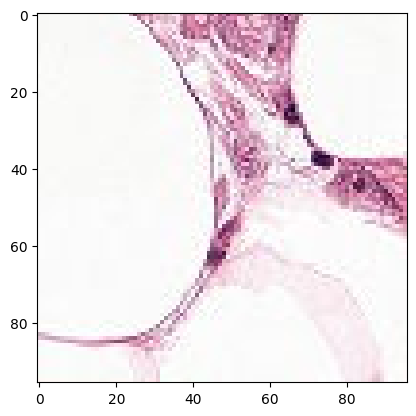

In [27]:
#pre processing the images for putting back into model and saving original iamges

def preprocess_image(img):
    # Resize and normalize the image
    transform = transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.ToTensor(),
    ])
    return transform(img)

input_images_list = os.listdir("input_images")

prepared_images = []
original_images = []

for i,image in enumerate(input_images_list):
    path_to_image = os.path.join("input_images", image)
    original_image = Image.open(path_to_image).convert('RGB')
    prepared_image = preprocess_image(original_image)
    prepared_images.append(prepared_image)
    original_images.append(original_image)

    out_file_name = str(i) + "_original.png"
    out_file_path = os.path.join("output_images",out_file_name)

    plt.imshow(original_image, alpha=1)
    plt.savefig(out_file_name, dpi=300, bbox_inches='tight')


In [ ]:
## Creating a new gradcam object and putting images through it for visualization
## Saving said images for the survey


target_layers = [model._modules['conv1'], model._modules['conv2'], model._modules['conv3']]

cam = GradCAM(model=model, target_layers=target_layers)


for i, image  in enumerate(prepared_images):
    input_tensor = image.unsqueeze(0)
    new_gcam_image = cam(input_tensor=input_tensor)
    new_gcam_image = new_gcam_image[0,:]


    out_file_name = str(i) + "_gradcam.png"
    out_file_path = os.path.join("output_images",out_file_name)


    plt.imshow(original_images[i], alpha=1)
    plt.imshow(new_gcam_image, cmap='jet', alpha=.2)

    plt.savefig(out_file_path, dpi=300, bbox_inches='tight')



100%|██████████| 4/4 [00:00<00:00, 11.55it/s]


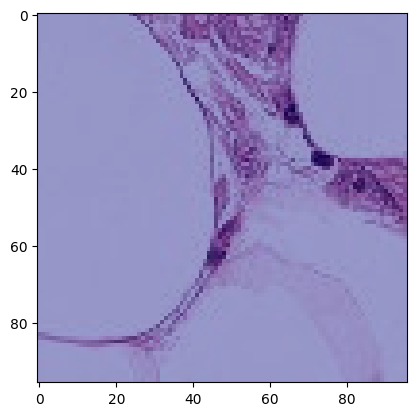

In [46]:
## Creating a new ScoreCam object and putting images through it for visualization
## Saving said images for the survey


target_layers = [model._modules['conv1'], model._modules['conv2'], model._modules['conv3']]

cam = ScoreCAM(model=model, target_layers=target_layers)


for i, image  in enumerate(prepared_images):
    input_tensor = image.unsqueeze(0)
    new_gcam_image = cam(input_tensor=input_tensor)
    new_gcam_image = new_gcam_image[0,:]


    out_file_name = str(i) + "_scorecam.png"
    out_file_path = os.path.join("output_images",out_file_name)


    plt.imshow(original_images[i], alpha=1)
    plt.imshow(new_gcam_image, cmap='jet', alpha=.4)

    plt.savefig(out_file_path, dpi=300, bbox_inches='tight')
    

    



In [ ]:
## Creating a new FullGrad object and putting images through it for visualization
## Saving said images for the survey


target_layers = [model._modules['conv1'], model._modules['conv2'], model._modules['conv3']]

cam = FullGrad(model=model, target_layers=target_layers)


for i, image  in enumerate(prepared_images):
    input_tensor = image.unsqueeze(0)
    new_gcam_image = cam(input_tensor=input_tensor)
    new_gcam_image = new_gcam_image[0,:]


    out_file_name = str(i) + "_fullgrad.png"
    out_file_path = os.path.join("output_images",out_file_name)


    plt.imshow(original_images[i], alpha=1)
    plt.imshow(new_gcam_image, cmap='jet', alpha=.4)

    plt.savefig(out_file_path, dpi=300, bbox_inches='tight')
    

In [ ]:
## Creating a new gradcam_plus_plus object and putting images through it for visualization
## Saving said images for the survey


target_layers = [model._modules['conv1'], model._modules['conv2'], model._modules['conv3']]

cam = GradCAMPlusPlus(model=model, target_layers=target_layers)


for i, image  in enumerate(prepared_images):
    input_tensor = image.unsqueeze(0)
    new_gcam_image = cam(input_tensor=input_tensor)
    new_gcam_image = new_gcam_image[0,:]


    out_file_name = str(i) + "_gradcam_plus_plus.png"
    out_file_path = os.path.join("output_images",out_file_name)


    plt.imshow(original_images[i], alpha=1)
    plt.imshow(new_gcam_image, cmap='jet', alpha=.2)

    plt.savefig(out_file_path, dpi=300, bbox_inches='tight')

